In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import qiskit
warnings.simplefilter("ignore")


#### Utils functions

In [13]:
def test_graphbuild(graph_data, graph_number=1):
    """
    Tests graph building from a graph_specs database by:
    1. Building the graph
    2. Printing nodes, neighbors and weight values
    3. Plotting the built graph
    if `graph_number` is None then all graphs in graph_data are built and tested
    Parameters:  
        graph_data (list(tuples)): graph_specs database
        graph_number (int): graph number to build and test.  
    Returns:
        None
    """
    plt.figure(figsize=(2,2))
    for g_num, g_data in graph_data.items():
        plt.clf()
        cond = True
        if graph_number is not None:
            cond = g_num == str(graph_number)
        if g_data and cond:
            G = nx.DiGraph()
            G.add_weighted_edges_from(g_data)
            # print nodes and neighbors
            for node, ngbrs in G.adjacency():
                for ngbr, edge_attr in ngbrs.items():
                    print("Node:{}, Neighbor:{}, Weight:{}".format(node, ngbr, edge_attr["weight"]))
            # plot
            options = {
            'with_labels': True,
            'node_color': 'red',
            'node_size': 175,
            'width': 2,
            'font_weight':'bold',
            'font_color': 'white',
            }
            nx.draw_circular(G, **options)
            plt.title('No. %s' % g_num, loc='right')
            plt.show()

def build_graph_database(graph_data):
    """
    Build graph database (dictionary of networkx.DiGraph) from graph_data dictionary.
    """
    graph_db= dict([('%d' %d, {'G':None, 'V':None, 'LUclass':None, '2Color':None}) 
                          for d in range(1,len(graph_data.keys()) + 1)])
    for (g_num, g_entry), (_, g_data) in zip(graph_db.items(), graph_data.items()):
        if g_data:
            G = nx.DiGraph()
            G.add_weighted_edges_from(g_data)
            g_entry['G'] = G
            g_entry['V'] = len(G.nodes)
    return graph_db
        
    
def _build_from_graph(graph, gate_type="controlled_phase_gate", verbose=True, state_vec=True):
    """
    Builds a circuit from a graph by applying a 2-qubit gate between a node (qubit) and its neighbors (qubits)
    Parameters:
        graph (networks.DiGraph): graph object
        gate_type (string): type of gate to apply. if gate_type="controlled_phase_gate" then applies H_a-CNOT_{a,b}-H_a where a,b are qubits
    """
    
    n_qubits = len(graph.nodes)
    q_reg = qiskit.QuantumRegister(n_qubits)
    c_reg = qiskit.ClassicalRegister(n_qubits)
    circ = qiskit.QuantumCircuit(q_reg, c_reg)
    for node, ngbrs in graph.adjacency():
        for ngbr, edge_attr in ngbrs.items():
            if gate_type == "controlled_phase_gate":
                circ.h(node-1)
                circ.cx(node-1, ngbr-1)
                circ.h(node-1)
                print("Adding {} between Node:{} and Neighbor:{}".format(gate_type, node, ngbr)) 
            else:
                pass
    if state_vec:
        return circ
    circ.measure(q_reg, c_reg)
    return circ

### Populate a Dictionary of graph specs  
The keys correspond to the graph numbers in Table V in arXiv:060296 (Hein et al.)

In [56]:
# Dictionary of graph specs, the keys correspond to the graph numbers in Table V in arXiv:060296 (Hein et al.)
graph_data = dict([('%d' %d, None) for d in range(1,46)])

graph_data['1'] = [(1, 2, 1.0)] 
graph_data['2'] = [(1, 2, 1.0), (1, 3, 1.0)]
graph_data['3'] = [(1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0)]
graph_data['4'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph_data['5'] = [(1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0)]
graph_data['6'] = [(1, 2, 1.0), (2, 3, 1.0), (2, 5, 1.0), (3, 4, 1.0)]
graph_data['7'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0)]
graph_data['8'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (5, 1, 1.0)]
graph_data['9'] = [(1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0), (1, 6, 1.0)]
graph_data['10'] = [(1, 6, 1.0), (2, 6, 1.0), (3, 6, 1.0), (4, 5, 1.0), (5, 6, 1.0)]
graph_data['11'] = [(1, 6, 1.0), (2, 6, 1.0), (3, 5, 1.0), (4, 5, 1.0), (5, 6, 1.0)]
graph_data['12'] = [(1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0), (6, 2, 1.0)]

### Build and test a particular graph (or all of them)

Node:1, Neighbor:2, Weight:1.0
Node:2, Neighbor:3, Weight:1.0
Node:3, Neighbor:4, Weight:1.0
Node:4, Neighbor:5, Weight:1.0
Node:6, Neighbor:2, Weight:1.0


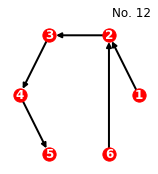

<Figure size 432x288 with 0 Axes>

In [57]:
test_graphbuild(graph_data, graph_number=12)

Build and return a dictionary of graph objects

In [58]:
graph_db = build_graph_database(graph_data)

### Build circuit from a graph

In [18]:
graph = graph_db['8']['G']
circ = _build_from_graph(graph,state_vec=False)

Adding controlled_phase_gate between Node:1 and Neighbor:2
Adding controlled_phase_gate between Node:2 and Neighbor:3
Adding controlled_phase_gate between Node:3 and Neighbor:4
Adding controlled_phase_gate between Node:4 and Neighbor:5
Adding controlled_phase_gate between Node:5 and Neighbor:1


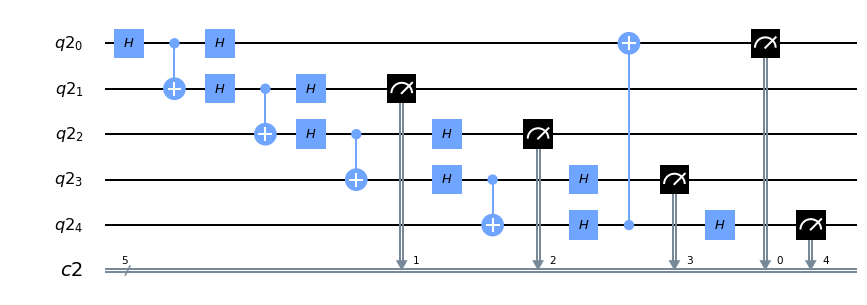

In [19]:
circ.draw()

## Random Disjoint Union of Graphs

In [188]:
def random_combine_subgraphs(graph_db, target_qubits=4):
    combs = list(set(partition(target_qubits)))
    sorted_dict = get_sorted_db(graph_db)
    graphs=[]
    for comb in combs:
        print('comb', comb)
        sub_graphs = []
        comb = list(comb)
        if len(comb) > 1:
            idx = 0
            while idx < len(comb):
                all_graphs = sorted_dict[comb[idx]]
                if len(all_graphs) < 1:
                    break
                graph_idx = random.randint(0, len(all_graphs)-1)
                sub_graphs.append(all_graphs[graph_idx])
                idx += 1
            print('comb={}, subgraphs={}'.format(comb, sub_graphs))
        else:
            all_graphs = sorted_dict[comb[0]]
            if len(all_graphs) > 0:
                graph_idx = random.randint(0, len(all_graphs)-1)
                sub_graphs.append(all_graphs[graph_idx])
                print('comb={}, subgraphs={}'.format(comb, sub_graphs))
        graphs.append(sub_graphs)
    idx = random.randint(0, len(graphs)-1)
    sub_graphs = graphs[idx]
    union_graph = nx.DiGraph()
    for sub_g in sub_graphs:
        union_graph = nx.disjoint_union(union_graph, sub_g)
    return union_graph
        
            

def get_sorted_db(gaph_db):
    sorted_dict = dict([(i, []) for i in range(1,len(graph_db.keys()))])
    for key, itm in graph_db.items():
        if itm["G"] is not None:
            sorted_key = len(itm["G"].nodes)
            sorted_dict[sorted_key].append(itm["G"])
    return sorted_dict
     
    
def partition(n, I=2):
    yield(n,)
    for i in range(I, n//2 + 1):
        for p in partition(n-i, i):
             yield (i,) + p

comb (2, 6)
comb=[2, 6], subgraphs=[<networkx.classes.digraph.DiGraph object at 0x7fb15af68ac8>, <networkx.classes.digraph.DiGraph object at 0x7fb15af682b0>]
comb (2, 2, 2, 2)
comb=[2, 2, 2, 2], subgraphs=[<networkx.classes.digraph.DiGraph object at 0x7fb15af68ac8>, <networkx.classes.digraph.DiGraph object at 0x7fb15af68ac8>, <networkx.classes.digraph.DiGraph object at 0x7fb15af68ac8>, <networkx.classes.digraph.DiGraph object at 0x7fb15af68ac8>]
comb (2, 2, 4)
comb=[2, 2, 4], subgraphs=[<networkx.classes.digraph.DiGraph object at 0x7fb15af68ac8>, <networkx.classes.digraph.DiGraph object at 0x7fb15af68ac8>, <networkx.classes.digraph.DiGraph object at 0x7fb15af68e80>]
comb (8,)
comb (2, 3, 3)
comb=[2, 3, 3], subgraphs=[<networkx.classes.digraph.DiGraph object at 0x7fb15af68ac8>, <networkx.classes.digraph.DiGraph object at 0x7fb15af689b0>, <networkx.classes.digraph.DiGraph object at 0x7fb15af689b0>]
comb (4, 4)
comb=[4, 4], subgraphs=[<networkx.classes.digraph.DiGraph object at 0x7fb15af6

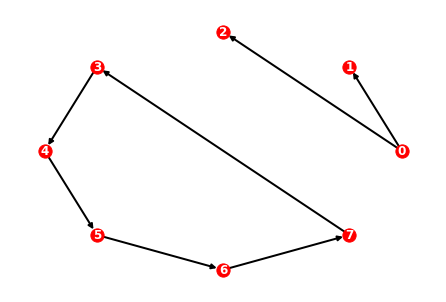

In [191]:
g  = random_combine_subgraphs(graph_db, target_qubits=8)
options = {
            'with_labels': True,
            'node_color': 'red',
            'node_size': 175,
            'width': 2,
            'font_weight':'bold',
            'font_color': 'white',
            }
nx.draw_circular(g, **options)